pip install "numpy<2"  
pip install onnxruntime

## Fine-tuning ResNet18 model with Imagenette

### Downloading Imagenette

In [ ]:
#| eval: false
import os
import urllib.request
import tarfile
from pathlib import Path

# Check if the dataset has already been downloaded; if not, download and extract it
# Define the URL for Imagenette-320 dataset and the path where it should be saved
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz"
data_dir = Path.cwd() / 'data'  # Use current working directory for data storage
dataset_path = data_dir / "imagenette2-320"

# Check if the dataset has already been downloaded; if not, download and extract it
if not dataset_path.exists():
    data_dir.mkdir(parents=True, exist_ok=True)
    
    # Download the dataset
    tar_path = data_dir / "imagenette2-320.tgz"
    urllib.request.urlretrieve(dataset_url, tar_path)
    
    # Extract the tar.gz file
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(path=data_dir)
    
    # Remove the tar.gz file after extraction
    os.remove(tar_path)

[ child for child in dataset_path.iterdir() ]

[PosixPath('/home/jetson/jetson-examples/tensorrt/data/imagenette2-320/noisy_imagenette.csv'),
 PosixPath('/home/jetson/jetson-examples/tensorrt/data/imagenette2-320/val'),
 PosixPath('/home/jetson/jetson-examples/tensorrt/data/imagenette2-320/train')]

In [ ]:
#| eval: false
import time
import torch
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import OneCycleLR
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision import models
from torchvision import utils as vutils
from tqdm import tqdm

/home/jetson/jetson-examples/tensorrt/venv/lib/python3.10/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/jetson/jetson-examples/tensorrt/venv/lib/python3.10/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


### Processing Imagenette

Training samples: 9469
Validation samples: 3925


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


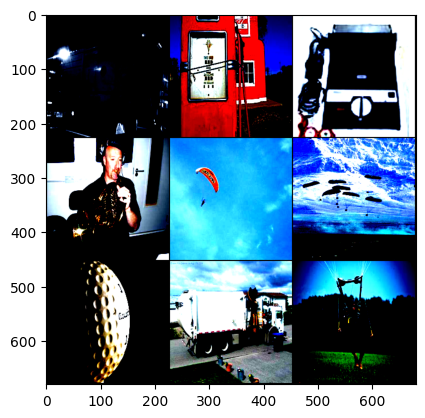

In [ ]:
#| eval: false
# Define the image transformations (resize and normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224 (height, width)
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet stats
])

# Load the training and validation datasets
train_dataset = datasets.ImageFolder(root=dataset_path / 'train', transform=transform)
val_dataset = datasets.ImageFolder(root=dataset_path / 'val', transform=transform)

# Create data loaders for training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Check the number of images in the training and validation sets
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Display a batch of images
def show_batch(loader):
    # Get one batch of images
    images, labels = next(iter(loader))
    # Convert the batch of images to a grid of images
    grid = vutils.make_grid(images[:9], nrow=3)
    # Plot the grid of images
    plt.imshow(grid.permute(1, 2, 0).numpy())  # Permute to (H, W, C) for matplotlib
    plt.show()

# Show a batch from the training set
show_batch(train_loader)

### Preparation

In [ ]:
#| eval: false
# Load pre-trained ResNet-18
model = models.resnet18(pretrained=True)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Device: {device}")

# Check the number of classes in the dataset
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

Device: cuda
Number of classes: 10


In [ ]:
#| eval: false
# Set up class for recording metrics
class Recorder:
    def __init__(self):
        self.durations = []
        self.losses = []
        self.accuracies = []

    def append(self, duration, loss, accuracy):
        self.durations.append(duration)
        self.losses.append(loss)
        self.accuracies.append(accuracy)

# Define the loss function
criterion = CrossEntropyLoss()

In [ ]:
#| eval: false
# Custom function to train the model using One-Cycle learning rate policy
def train(model, train_loader, criterion, optimizer, epochs, lr_max, pct_start, div, device, recorder=None):
    """Train the model using a One-Cycle learning rate policy."""
    scheduler = OneCycleLR(
        optimizer, 
        max_lr=lr_max, 
        total_steps=len(train_loader)*epochs, 
        pct_start=pct_start, 
        div_factor=div)

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        start_time = time.time()

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for inputs, labels in progress_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_time = time.time() - start_time
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        if recorder:
            recorder.append(epoch_time, epoch_loss, epoch_acc)

        print(f"Epoch {epoch+1}/{epochs}, Duration: {epoch_time:.0f}s, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

In [ ]:
#| eval: false
def validate(model, val_loader, criterion, device, recorder=None):
    """Validate the model and return loss and accuracy."""
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    start_time = time.time()
    
    progress_bar = tqdm(val_loader, desc="Validating", leave=False)
    
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            progress_bar.set_postfix(loss=loss.item())
    
    val_time = time.time() - start_time
    val_loss = running_loss / len(val_loader.dataset)
    val_acc = running_corrects.double() / len(val_loader.dataset)
    if recorder:
        recorder.append(val_time, val_loss, val_acc)
    
    print(f"Validation, Duration: {val_time:.0f}s, Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
    return val_loss, val_acc

### Fine-tune

In [ ]:
#| eval: false
# Set up parameters for fine-tuning
epochs=3
freeze_epochs=1

base_lr=2e-3 
lr_mult=100
pct_start=0.3
div=5.0

In [ ]:
#| eval: false
# Freeze all the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

# Modify the last layer of the model
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.to(device)

# Set up the optimizer
optimizer = Adam(model.fc.parameters(), lr=base_lr)

# Train the model with the new head
print(f"Training the last layer only for {freeze_epochs} epochs...")
train(model, train_loader, criterion, optimizer, freeze_epochs, base_lr, pct_start, div, device)

Training the last layer only for 1 epochs...


Epoch 1/1, Duration: 85s, Loss: 0.5405, Accuracy: 0.8701


In [ ]:
#| eval: false
# Unfreeze all the layers
for param in model.parameters():
    param.requires_grad = True

# Adam optimizer for full model
optimizer = Adam(model.parameters(), lr=base_lr/lr_mult)

# Train the full model
print(f"Fine-tuning the full model for {epochs} epochs...")
train_recorder = Recorder()
train(model, train_loader, criterion, optimizer, epochs, base_lr, pct_start, div, device, train_recorder)

Fine-tuning the full model for 3 epochs...


Epoch 1/3, Duration: 114s, Loss: 0.5509, Accuracy: 0.8337


Epoch 2/3, Duration: 114s, Loss: 0.3932, Accuracy: 0.8771


Epoch 3/3, Duration: 114s, Loss: 0.1137, Accuracy: 0.9655


In [ ]:
#| eval: false
print("Validating the model...")
val_recorder = Recorder()
validate(model, val_loader, criterion, device, val_recorder)

Validating the model...


Validation, Duration: 34s, Loss: 0.2098, Accuracy: 0.9297


(0.20980065250852306, tensor(0.9297, device='cuda:0', dtype=torch.float64))

In [ ]:
#| eval: false
model.eval()

# Create 'models' directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the model to a file
model_path = Path.cwd() / 'models' / 'resnet18_imagenette.pth'
torch.save(model.state_dict(), model_path)

## Acceleration with Torch-TensorRT

https://pytorch.org/TensorRT/getting_started/jetpack.html

In [ ]:
#| eval: false
import time
import torch
import torch_tensorrt
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from pathlib import Path
from tqdm import tqdm

In [ ]:
#| eval: false
def get_validation_loader(dataset_path, batch_size=16):
    """Load the validation dataset and return a DataLoader."""
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_dataset = datasets.ImageFolder((dataset_path / 'val'), transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    return val_loader

In [ ]:
#| eval: false
# Load the model
def load_model(
        model_path, 
        device = 'cuda',  # Use 'cuda' if GPU is available, else use 'cpu'
        num_classes = 10,  # Number of classes in the dataset imagenette2-320
        use_fp16 = False,  # Use FP16 precision for TensorRT
):
    """Load the model from the specified path and set it to evaluation mode."""
    model = models.resnet18()
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(model_path))
    if use_fp16:
        model = model.half()
    model.to(device).eval()
    return model

In [ ]:
#| eval: false
def optimize_model_tensorrt(model, use_fp16=False, device='cuda:0'):
    """Optimize the model with TensorRT in either FP32 or FP16"""
    compile_spec = {
        "inputs": [
            torch_tensorrt.Input(
                min_shape=(1, 3, 224, 224),
                opt_shape=(8, 3, 224, 224),
                max_shape=(64, 3, 224, 224),
                dtype=torch.half if use_fp16 else torch.float
            )
        ],
        "enabled_precisions": {torch.half if use_fp16 else torch.float},
        "ir": "dynamo"
    }
    return torch_tensorrt.compile(model, **compile_spec, device=torch.device(device))

In [ ]:
#| eval: false
def evaluate_model(model, dataloader, device, use_fp16=False):
    """Evaluate accuracy & inference time for a given batch size"""
    total_time = 0.0
    running_corrects = 0

    progress_bar = tqdm(dataloader, desc="Evaluating performance...", leave=False)
    
    for inputs, labels in progress_bar:
            if use_fp16:
                inputs = inputs.half()
        
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            start_time = time.time()
            outputs = model(inputs)
            total_time += time.time() - start_time
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
    inf_acc = float(running_corrects.double() / len(dataloader.dataset))
    avg_time = total_time / len(dataloader.dataset)

    return inf_acc, total_time, avg_time

In [ ]:
#| eval: false
# Build different models with optimizations for comparison
model_path = Path.cwd() / 'models' / 'resnet18_imagenette.pth'
baseline_model = load_model(model_path, use_fp16=False)
baseline_fp16_model = load_model(model_path, use_fp16=True)

start_time = time.time()  # Start time for compiling the models
trt_fp32_model = optimize_model_tensorrt(baseline_model, use_fp16=False)
print(f"FP32 model compiled in {time.time() - start_time:.2f} seconds")

start_time = time.time()
trt_fp16_model = optimize_model_tensorrt(baseline_fp16_model, use_fp16=True)
print(f"FP16 model compiled in {time.time() - start_time:.2f} seconds")

  model.load_state_dict(torch.load(model_path))



FP32 model compiled in 18.10 seconds


FP16 model compiled in 50.01 seconds


In [ ]:
#| eval: false
# Initialize inference
results = []
batch_sizes = [1, 8, 16, 32, 64]
dataset_path = Path.cwd() / 'data' / 'imagenette2-320'

for batch_size in batch_sizes:
    # Load validation dataset for each batch size
    val_loader = get_validation_loader(dataset_path, batch_size=batch_size)

    # Evaluate different models
    print(f"Evaluating models with batch size {batch_size}...")
    baseline_acc, baseline_total_time, baseline_avg_time = evaluate_model(baseline_model, val_loader, device, use_fp16=False)
    results.append([batch_size, "Baseline", baseline_acc, baseline_total_time, baseline_avg_time])
    trt_fp32_acc, trt_fp32_total_time, trt_fp32_avg_time = evaluate_model(trt_fp32_model, val_loader, device, use_fp16=False)
    results.append([batch_size, "TensorRT FP32", trt_fp32_acc, trt_fp32_total_time, trt_fp32_avg_time])
    baseline_fp16_acc, baseline_fp16_total_time, baseline_fp16_avg_time = evaluate_model(baseline_fp16_model, val_loader, device, use_fp16=True)
    results.append([batch_size, "Baseline FP16", baseline_fp16_acc, baseline_fp16_total_time, baseline_fp16_avg_time])
    trt_fp16_acc, trt_fp16_total_time, trt_fp16_avg_time = evaluate_model(trt_fp16_model, val_loader, device, use_fp16=True)
    results.append([batch_size, "TensorRT FP16", trt_fp16_acc, trt_fp16_total_time, trt_fp16_avg_time])

df_results = pd.DataFrame(results, columns=["Batch Size", "Model", "Accuracy", "Total Time", "Average Time"])
df_results

Evaluating models with batch size 1...


Evaluating models with batch size 8...


Evaluating models with batch size 16...


Evaluating models with batch size 32...


Evaluating models with batch size 64...


,Batch Size,Model,Accuracy,Total Time,Average Time
0,1,Baseline,0.929682,43.348487,0.011044
1,1,TensorRT FP32,0.929682,8.231340,0.002097
2,1,Baseline FP16,0.929682,48.804268,0.012434
3,1,TensorRT FP16,0.929682,17.782847,0.004531
4,8,Baseline,0.929682,6.542611,0.001667
5,8,TensorRT FP32,0.929682,2.076011,0.000529
6,8,Baseline FP16,0.929682,7.189516,0.001832
7,8,TensorRT FP16,0.929682,3.168359,0.000807
8,16,Baseline,0.929682,3.964534,0.001010
9,16,TensorRT FP32,0.929682,1.630216,0.000415


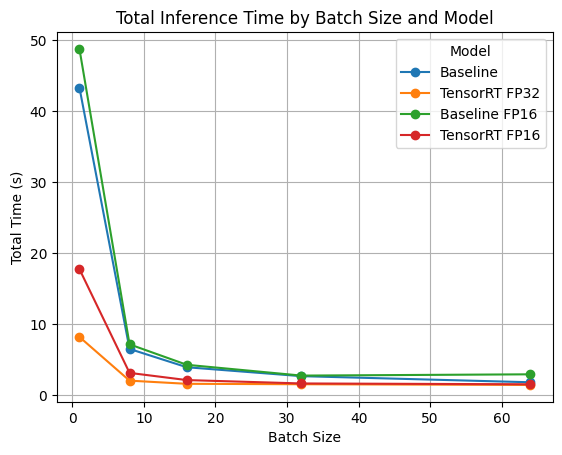

In [ ]:
#| eval: false
# Get unique models
models = df_results["Model"].unique()

# Line Plot for Total Inference Time by Batch Size
for model in models:
    subset = df_results[df_results["Model"] == model]
    plt.plot(subset["Batch Size"], subset["Total Time"], marker='o', linestyle='-', label=model)

plt.title("Total Inference Time by Batch Size and Model")
plt.ylabel("Total Time (s)")
plt.xlabel("Batch Size")
plt.legend(title="Model")
plt.grid(True)
plt.show()

In [ ]:
#| eval: false
# Compute Speed-up by TensorRT Compilation (same precision)
speedup_data = []
for baseline_name in ["Baseline", "Baseline FP16"]:
    for batch_size in df_results["Batch Size"].unique():
        precision = "FP16" if baseline_name == "Baseline FP16" else "FP32"
        baseline_time = df_results[(df_results["Batch Size"] == batch_size) & (df_results["Model"] == baseline_name)]["Total Time"].values
        tensorrt_time = df_results[(df_results["Batch Size"] == batch_size) & (df_results["Model"] == f"TensorRT {precision}")]["Total Time"].values
        if len(baseline_time) > 0 and len(tensorrt_time) > 0:
            speedup = baseline_time[0] / tensorrt_time[0]
            speedup_data.append({"Batch Size": batch_size, "Precision": precision, "Speed-up": speedup})

speedup_df = pd.DataFrame(speedup_data)
speedup_df

,Batch Size,Precision,Speed-up
0,1,FP32,5.266273
1,8,FP32,3.151530
2,16,FP32,2.431907
3,32,FP32,1.723206
4,64,FP32,1.253296
5,1,FP16,2.744458
6,8,FP16,2.269161
7,16,FP16,1.998309
8,32,FP16,1.658745
9,64,FP16,1.898521


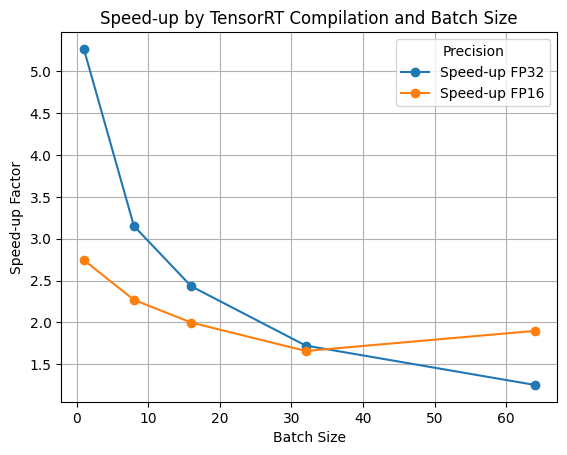

In [ ]:
#| eval: false
# Line Plot for Speed-up by Batch Size
for precision in speedup_df["Precision"].unique():
    subset = speedup_df[speedup_df["Precision"] == precision]
    plt.plot(subset["Batch Size"], subset["Speed-up"], marker='o', linestyle='-', label=f"Speed-up {precision}")

plt.title("Speed-up by TensorRT Compilation and Batch Size")
plt.ylabel("Speed-up Factor")
plt.xlabel("Batch Size")
plt.legend(title="Precision")
plt.grid(True)
plt.show()

## Acceleration with ONNX Runtime with TensorRT execution provider

https://pytorch.org/TensorRT/getting_started/installation.html
Building Natively on aarch64 (Jetson)

Test with inference using the validation dataset

In [ ]:
#| eval: false
import os
import random
import numpy as np
from PIL import Image
from pathlib import Path

Categories: n01440764, n02102040, n02979186, n03000684, n03028079, n03394916, n03417042, n03425413, n03445777, n03888257
Number of validation images: 3925
Image from category n03417042 (index 6): n03417042_5600.JPEG


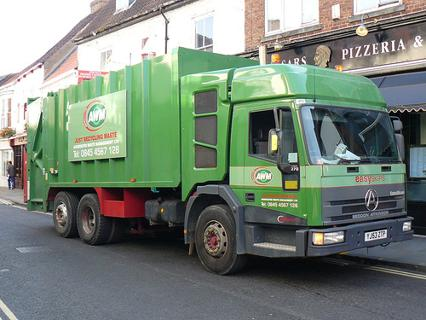

In [ ]:
#| eval: false
# Load the dataset and categories
dataset_path = Path.cwd() / 'data' / 'imagenette2-320'
categories = sorted(os.listdir(dataset_path / 'train'))
print(f"Categories: {', '.join(categories)}")

# Construct random samples from each category 
val_data = list((dataset_path / 'val').rglob('*.JPEG'))
print(f"Number of validation images: {len(val_data)}")

# Load a sample image
image_path = val_data[random.randint(0, len(val_data))]
print(f"Image from category {image_path.parent.name} (index {categories.index(image_path.parent.name)}): {image_path.name}")
Image.open(image_path)

In [ ]:
#| eval: false
def load_image(image_path, target_size=(224, 224)):
    """Load and preprocess the image."""
    image = Image.open(image_path).convert('RGB')
    image = image.resize(target_size)
    image_array = np.array(image).astype(np.float32)

    # Normalize the image (ResNet-18 normalization mean and std values)
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)

    image_array = (image_array / 255.0 - mean) / std

    # Reshape to (1, 3, 224, 224) as expected by the model
    image_array = np.transpose(image_array, (2, 0, 1))  # HWC -> CHW
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    return image_array

image_array = load_image(image_path)
image_array.shape

(1, 3, 224, 224)

### ONNX

To test TensorRT acceleration, a PyTorch model is first converted to ONNX using `torch.onnx.export()`. TensorRT then optimizes the ONNX model for NVIDIA GPUs by applying techniques like layer fusion, precision reduction (FP16/INT8), and kernel tuning. The result is a highly efficient TensorRT engine for accelerated inference.

In [ ]:
#| eval: false
import torch.onnx

In [ ]:
#| eval: false
# Define a dummy input with the shape (1, 3, 224, 224)
dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Move the dummy input to the same device as the model

# Define the path for the ONNX export
onnx_model_path = "models/resnet18_imagenette.onnx"  # Save to 'models' directory

# Export the model to ONNX format
model.eval()
torch.onnx.export(
    model, 
    dummy_input, 
    onnx_model_path, 
    input_names=["input"], 
    output_names=["output"]
)

print(f"Original pre-trained model exported to {onnx_model_path}")

Original pre-trained model exported to models/resnet18_imagenette.onnx


#### ONNX runtime with TensorRT as execution context
[ONNX Runtime](https://onnxruntime.ai/) supports Python API for running inference from an .onnx model. It can also be accelerated by using TensorRT as its execution context. TensorRT has to be installed beforehand, and its path should be set with:

```sh
$ export LD_LIBRARY_PATH=/usr/lib/aarch64-linux-gnu:$LD_LIBRARY_PATH
```

Then, `onnxruntime_gpu` needs to be installed via a custom wheel provided by NVIDIA for Jetson devices. Follow this [link](https://pypi.jetson-ai-lab.dev/), select the JetPack and CUDA of your device, and download a suitable wheel depending on the Python version. For example, with JetPack 6+, CUDA 12.6, and Python=3.10, `onnxruntime_gpu==1.20.0` will be installed in this tutorial:

```sh
$ wget https://pypi.jetson-ai-lab.dev/jp6/cu126/+f/0c4/18beb3326027d/onnxruntime_gpu-1.20.0-cp310-cp310-linux_aarch64.whl#sha256=0c418beb3326027d83acc283372ae42ebe9df12f71c3a8c2e9743a4e323443a4
$ pip install onnxruntime_gpu-1.20.0-cp310-cp310-linux_aarch64.whl

```

Verify the installation with:

In [ ]:
#| eval: false
import onnxruntime as ort
print(ort.get_device())                 # Should print 'GPU' or 'CPU'
print(ort.get_available_providers())    # Should print 
# ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']

GPU
['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


In this tutorial, construct multiple sessions ...

In [ ]:
#| eval: false
import time
import onnxruntime as ort
import numpy as np

In [ ]:
#| eval: false
def run_inference(session, image_array):
    """Run inference, apply softmax, and get the predicted class."""
    # Get input and output names
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name
    
    # Run inference
    logits = session.run([output_name], {input_name: image_array})[0]
    
    # Apply softmax to logits to get probabilities
    probabilities = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
    
    # Get the predicted class
    predicted_class = np.argmax(probabilities)
    
    return predicted_class, probabilities

In [ ]:
#| eval: false
# Define the path to the exported ONNX model
onnx_model_path = "models/resnet18_imagenette.onnx"

# Construct multiple InferenceSession objects with different providers
cpu_session = ort.InferenceSession(onnx_model_path)
cuda_session = ort.InferenceSession(
    onnx_model_path, 
    providers=[
        ("CUDAExecutionProvider", {
            "device_id": 0,                                 # Use the first available GPU
            "arena_extend_strategy": "kNextPowerOfTwo",     # Efficient memory management
            "gpu_mem_limit": 2 * 1024 * 1024 * 1024,        # Limit memory usage (adjust for Jetson Nano)
            "cudnn_conv_algo_search": "EXHAUSTIVE",         # Optimize convolution algorithms
            "do_copy_in_default_stream": True,              # Reduce synchronization overhead
        })
    ]
)
trt_session = ort.InferenceSession(
    onnx_model_path, 
    providers=[
        ('TensorrtExecutionProvider', {
            'device_id': 0,                          # Select GPU to execute
            'trt_max_workspace_size': 2147483648,    # Set GPU memory usage limit (e.g., 2GB)
            'trt_fp16_enable': True,                 # Enable FP16 precision for faster inference
        }),
    ]
)

In [ ]:
#| eval: false
# Run inference with the CPU provider
start_time = time.time()
predicted_class, probabilities = run_inference(cpu_session, image_array)
end_time = time.time()

print(f"Predicted Class: {predicted_class}")
print(f"Inference Time: {end_time - start_time} seconds")
print(f"Class Probabilities: {probabilities}")

Predicted Class: 6
Inference Time: 0.06018710136413574 seconds
Class Probabilities: [[2.8983616e-10 6.2775657e-10 4.6363002e-07 2.1837502e-08 3.9283857e-10
  4.3800658e-10 9.9999607e-01 3.4335710e-06 5.4752858e-10 1.5945385e-09]]


In [ ]:
#| eval: false
# Note: If inference time is slow, try running this cell again
# because the first inference might involve additional setup time for CUDA
# Run inference with the CUDA provider
start_time = time.time()
predicted_class, probabilities = run_inference(cuda_session, image_array)
end_time = time.time()

print(f"Predicted Class: {predicted_class}")
print(f"Inference Time: {end_time - start_time} seconds")
print(f"Class Probabilities: {probabilities}")

Predicted Class: 6
Inference Time: 0.02844691276550293 seconds
Class Probabilities: [[2.9011216e-10 6.2827110e-10 4.6380845e-07 2.1848063e-08 3.9324449e-10
  4.3827234e-10 9.9999607e-01 3.4338229e-06 5.4782839e-10 1.5960537e-09]]


In [ ]:
#| eval: false
# Run inference with the TensorRT provider
start_time = time.time()
predicted_class, probabilities = run_inference(trt_session, image_array)
end_time = time.time()

print(f"Predicted Class: {predicted_class}")
print(f"Inference Time: {end_time - start_time} seconds")
print(f"Class Probabilities: {probabilities}")

Predicted Class: 6
Inference Time: 0.013691186904907227 seconds
Class Probabilities: [[2.9462538e-10 6.3354416e-10 4.6735542e-07 2.1986956e-08 3.9646181e-10
  4.4228510e-10 9.9999607e-01 3.4545803e-06 5.5474980e-10 1.6052217e-09]]


In [ ]:
#| eval: false
# Arrays to store inference times and accuracies for different sessions
session_names = ["CPU", "CUDA", "TensorRT"]
session_times = [[] for _ in session_names]
session_accs  = [[] for _ in session_names]

# Run inference on all images in the validation set
for image_path in val_data:
    try:
        image_array = load_image(image_path)
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        raise e
    for i, session in enumerate([cpu_session, cuda_session, trt_session]):
        start_time = time.time()
        predicted_class, _ = run_inference(session, image_array)
        end_time = time.time()
        
        session_times[i].append(end_time - start_time)
        session_accs[i].append(predicted_class == categories.index(image_path.parent.name))

# Report inference time and accuracy for each session
for i, session_name in enumerate(session_names):
    total_time = np.sum(session_times[i])
    avg_accuracy = np.mean(session_accs[i])
    print(f"{session_name} - Total Inference Time: {total_time:.4f} seconds, Accuracy: {avg_accuracy:.4f}")

CPU - Total Inference Time: 180.5405 seconds, Accuracy: 0.9292
CUDA - Total Inference Time: 77.7771 seconds, Accuracy: 0.9289
TensorRT - Total Inference Time: 18.4968 seconds, Accuracy: 0.9292
